In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
from collections import defaultdict
import random
from functools import reduce

import deepdish as dd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from scipy.special import softmax
from scipy.stats import pearsonr
from datasets import load_metric
import torch
import pingouin as pg

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
sns.set(font_scale=1.3)


In [2]:
# prediction measures
def avg_disagreement(logits_0, logits_1):
    agree = (logits_0.argmax(axis=-1) == logits_1.argmax(axis=-1))
    avg_agree = np.sum(agree) / logits_0.shape[0]
    return 1 - avg_agree


def jsd(logits_0, logits_1):
    p = softmax(logits_0, axis=-1)
    q = softmax(logits_1, axis=-1)
    m = (p + q) / 2.0
    klp = np.sum(p * (np.log(p) - np.log(m)), axis=-1)
    klq = np.sum(q * (np.log(q) - np.log(m)), axis=-1)
    return (klp + klq) / 2


def fleiss_kappa(logits_list):
    r"""See also https://www.real-statistics.com/reliability/interrater-reliability/fleiss-kappa/"""
    pred_lists = np.stack([logits.argmax(axis=-1) for logits in logits_list]).T  # num_subjects, num_judges
    num_subjects, num_judges = pred_lists.shape
    pred_ones = np.sum(pred_lists == 1, axis=-1)
    pred_zeros = np.sum(pred_lists == 0, axis=-1)
    agreement_matrix = np.stack((pred_zeros, pred_ones))  # num_subjects, num_labels

    p_i = (pred_ones * pred_ones + pred_zeros * pred_zeros - num_judges) / (num_judges * (num_judges - 1))
    p_a = np.mean(p_i)
    q_j = np.sum(agreement_matrix, axis=0) / (num_judges * num_subjects)
    p_eps = np.sum(q_j * q_j)

    kappa = (p_a - p_eps) / (1 - p_eps)
    return float(kappa)

In [3]:
def res_dir(model_name):
    return f'results/{model_name}/instability_eval'

def rep_dir(model_name):
    return os.path.join(res_dir(model_name), 'representation_measures')

def pred_dir(model_name):
    return os.path.join(res_dir(model_name), 'predictions')

task2metric = {'rte': 'accuracy', 'mrpc': 'f1', 
               'cola': 'matthews_correlation', 'sst2': 'accuracy'}
task2name = {'rte': 'RTE', 'mrpc': 'MRPC', 'cola': 'CoLA', 'sst2': 'SST-2'}
metric2abv = {'rte': 'Acc', 'mrpc': 'F1', 'cola': 'MCC', 'sst2': 'Acc'}
pm2symbol = {
    'avg_disagreement': '$\mathcal{I}_{\mathrm{pwd}}$',
    'fleiss_kappa': '$\mathcal{I}_{\mathrm{\kappa}}$',
    'jsd': '$\mathcal{I}_{\mathrm{JSD}}$',
    'std_accuracy': '$SD$',
    'std_f1': '$SD$',
    'std_matthews_correlation': '$SD$',
    'avg_accuracy': '$Acc$',
    'avg_f1': '$F1$',
    'avg_matthews_correlation': '$MCC$'
}
rm2symbol = {
    'svcca_dists': '$\mathcal{I}_{\mathrm{SVCCA}}$',
    'op_dists': '$\mathcal{I}_{\mathrm{OP}}$',
    'cka_dists': '$\mathcal{I}_{\mathrm{CKA}}$',
}
rm_run_type2symbol = {
    'svcca_dists': ['$\mathcal{I}_{SVCCA}^{s}$', '$\mathcal{I}_{SVCCA}^{f}$'],
    'cka_dists': ['$\mathcal{I}_{CKA}^{s}$', '$\mathcal{I}_{CKA}^{f}$'],
    'op_dists': ['$\mathcal{I}_{OP}^{s}$', '$\mathcal{I}_{OP}^{f}$'],
}
rm2marker = {
    'svcca_dists': 'o',
    'op_dists': 'v',
    'cka_dists': '^'
}
pm2marker = {
    'avg_disagreement': '*',
    'fleiss_kappa': '1',
    'jsd': '+',
    'std_accuracy': 'x',
    'std_f1': 'x',
    'std_matthews_correlation': 'x'
}
markers = ['*', '1', '+', 'x']
model_full_name_dict = {'bert': 'bert-large-uncased', 'roberta': 'roberta-large'}
latex_format = {
    'avg_disagreement': '$\mathcal{I}_{\mathrm{pwd}}$',
    'fleiss_kappa': '$\mathcal{I}_{\mathrm{\kappa}}$',
    'jsd': '$\mathcal{I}_{\mathrm{JSD}}$',
    'cka_dists': '$d_{CKA}$',
    'op_dists': '$d_{OP}$',
}

### Insensitivity to Sub-sampling

Model: bert, Task: RTE Sample Rate: 0.5


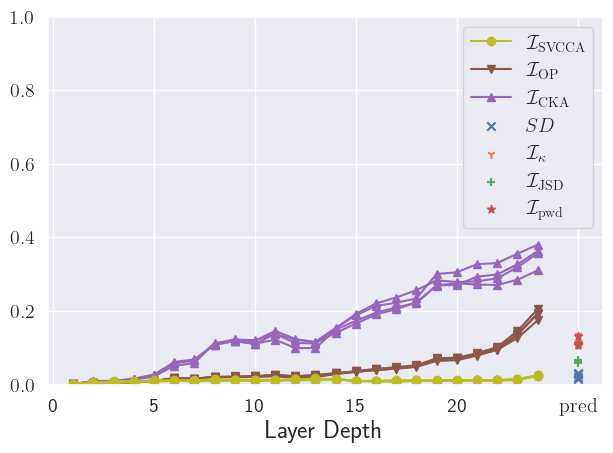

Model: roberta, Task: RTE Sample Rate: 0.5


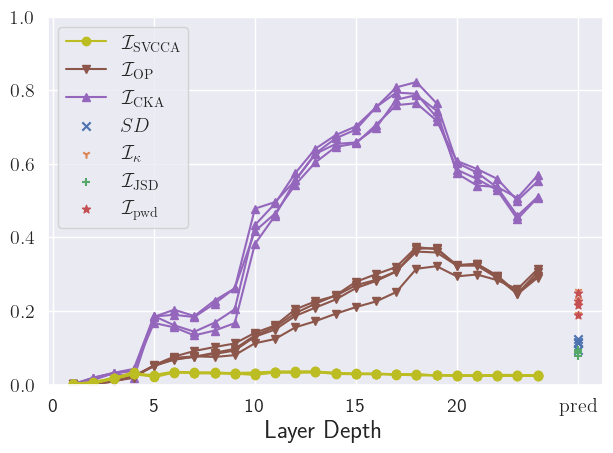

Model: bert, Task: MRPC Sample Rate: 0.5


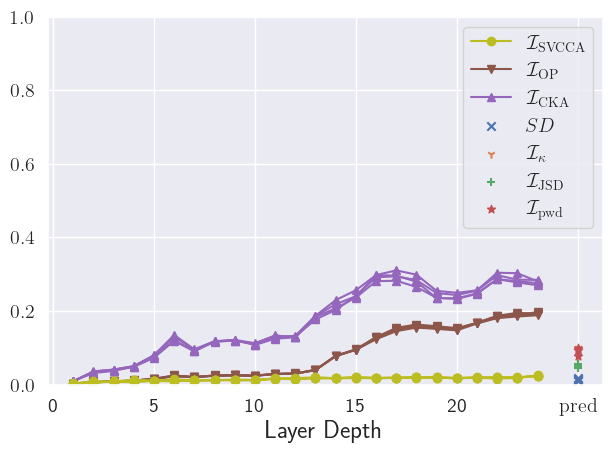

Model: roberta, Task: MRPC Sample Rate: 0.5


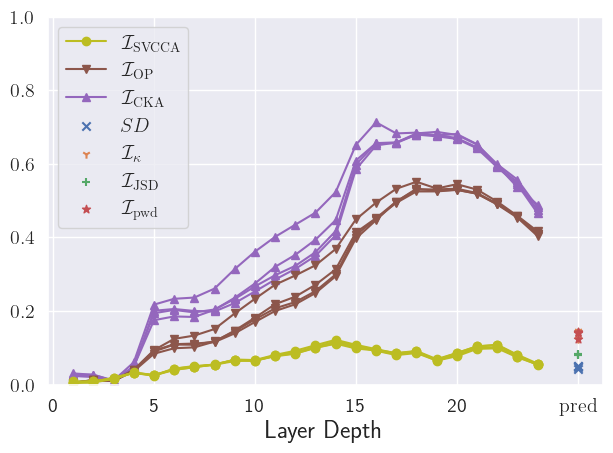

Model: bert, Task: CoLA Sample Rate: 0.5


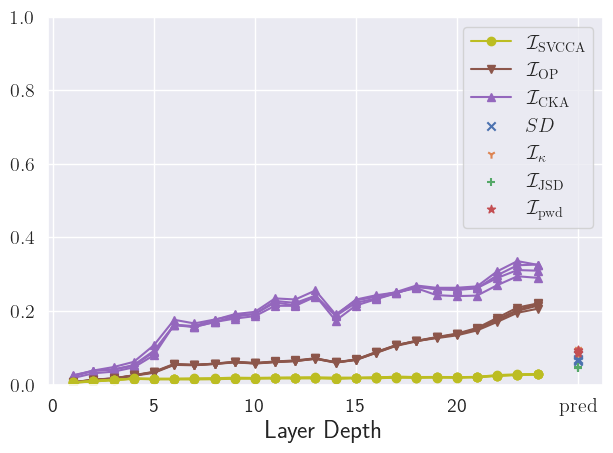

Model: roberta, Task: CoLA Sample Rate: 0.5


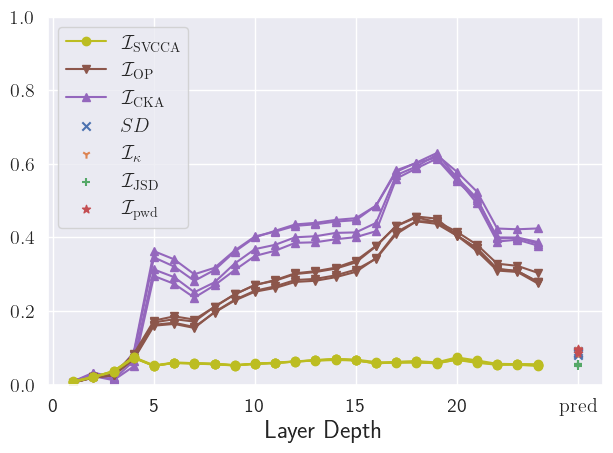

Model: bert, Task: RTE Sample Rate: 0.1


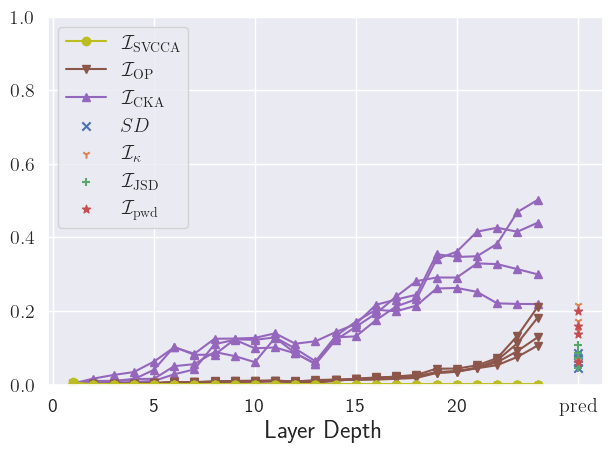

Model: roberta, Task: RTE Sample Rate: 0.1


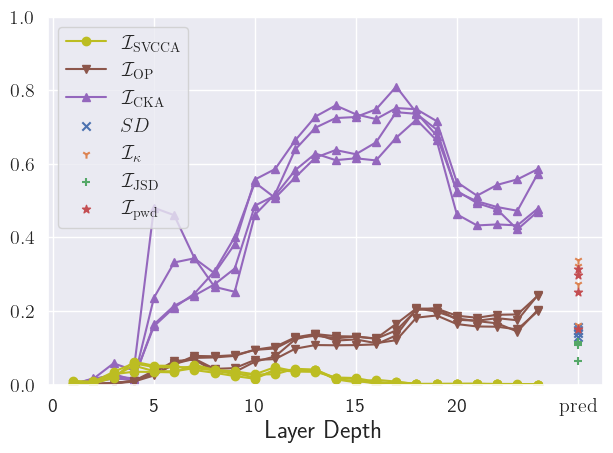

Model: bert, Task: MRPC Sample Rate: 0.1


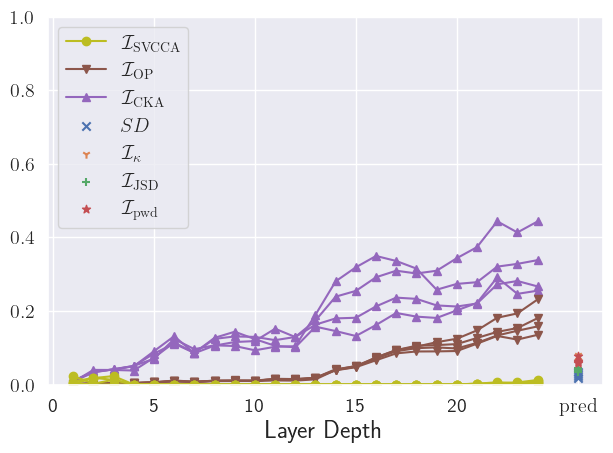

Model: roberta, Task: MRPC Sample Rate: 0.1


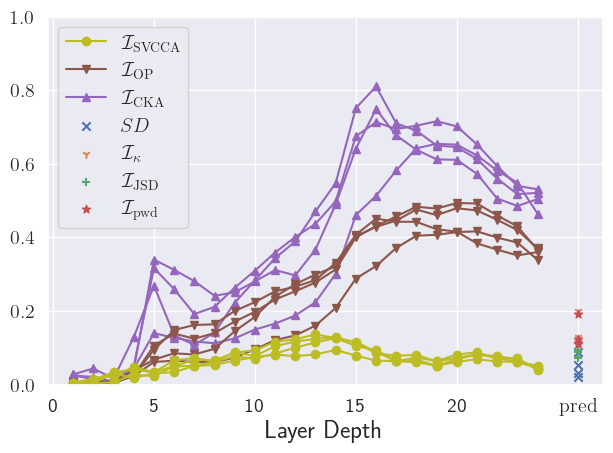

Model: bert, Task: CoLA Sample Rate: 0.1


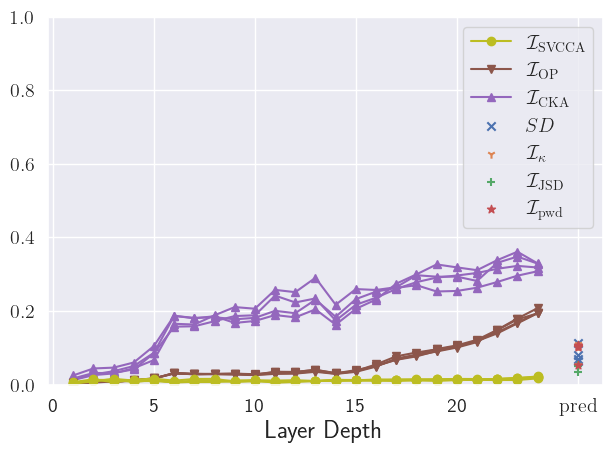

Model: roberta, Task: CoLA Sample Rate: 0.1


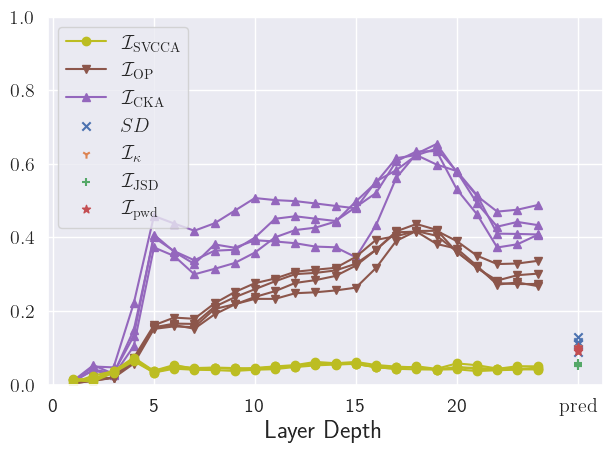

In [5]:
model_names = ['bert', 'roberta']
task_names = ['rte', 'mrpc', 'cola']

lr = '2e-05'
sample_times = 4
sample_rates = [0.5, 0.1]
rm2color = {
    'cka_dists': 'tab:purple',
    'op_dists': 'tab:brown',
    'svcca_dists': 'tab:olive'
}
seeds = list(range(10))

mask_idx = np.triu_indices(10, k=1)
for sample_rate in sample_rates:
    for task_name in task_names:
        metric = load_metric("glue", task_name)
        chosen_metric = task2metric[task_name]
        for model_name in model_names:
            pred_h5_path = os.path.join(
                pred_dir(model_name), f'{task_name}_{lr}_original.h5')
            # metric/labels/logits {seed:}
            pred_dict = dd.io.load(pred_h5_path)['test']  
            logits_dict, label_dict = pred_dict['logits'], pred_dict['labels']
            num_examples = label_dict[seeds[0]].shape[0]
    
            pred_measure_dict = defaultdict(list)
            for sample_time in range(sample_times):
                sample_indices = np.random.choice(
                    num_examples, size=int(num_examples * sample_rate), 
                    replace=False)
        
                sample_metric_values, sample_logits, \
                jsd_values, disagreement_values = [], [], [], []
                for seed_0_idx, seed_0 in enumerate(seeds):
                    sample_logits_0 = logits_dict[seed_0][sample_indices]
                    sample_metric_values.append(metric.compute(
                        predictions=sample_logits_0.argmax(axis=-1), 
                        references=label_dict[seed_0][sample_indices]
                        )[chosen_metric])
                    sample_logits.append(sample_logits_0)
    
                    for seed_1 in seeds[seed_0_idx + 1:]:
                        sample_logits_1 = logits_dict[seed_1][sample_indices]
                        jsd_values.append(
                            np.mean(jsd(sample_logits_0, sample_logits_1)))
                        disagreement_values.append(
                            avg_disagreement(sample_logits_0, sample_logits_1))
    
                pred_measure_dict[f'std_{chosen_metric}'].append(
                    np.std(sample_metric_values))
                pred_measure_dict['fleiss_kappa'].append(
                    1 - fleiss_kappa(sample_logits))
                pred_measure_dict['jsd'].append(np.mean(jsd_values))
                pred_measure_dict['avg_disagreement'].append(
                    np.mean(disagreement_values))
    
                h5_path = os.path.join(
                    rep_dir(model_name), 'subsample', 
                    f'{task_name}_{lr}_{sample_rate}_{sample_times}.h5')
                rep_dict = dd.io.load(h5_path)
    
                legend_elements = [
                    Line2D([0], [0], marker='o', 
                        color=rm2color['svcca_dists'], 
                        label=rm2symbol['svcca_dists']),
                    Line2D([0], [0], marker='v', 
                        color=rm2color['op_dists'], 
                        label=rm2symbol['op_dists']),
                    Line2D([0], [0], marker='^', 
                        color=rm2color['cka_dists'], 
                        label=rm2symbol['cka_dists'])
                ]
    
            for measure in pred_measure_dict:
                marker=pm2marker[measure]
                scatter_legend = plt.scatter(
                    [26 for _ in range(sample_times)], pred_measure_dict[measure],
                    label=pm2symbol[measure], marker=marker)
                legend_elements.append(scatter_legend)
    
            for measure in rep_dict:
                dists = np.mean(rep_dict[measure][mask_idx], axis=0)
                for dist_idx, dist in enumerate(dists):
                    plt.plot(np.arange(1, 25), dist, 
                            marker=rm2marker[measure], 
                            color=rm2color[measure])
            plt.ylim(0, 1)
            plt.xlabel('Layer Depth', fontsize=18)
            plt.xticks([0, 5, 10, 15, 20, 26], 
                    ['0', '5', '10', '15', '20', '$\mathrm{pred}$'])
            print(f'Model: {model_name}, Task: {task2name[task_name]}', 
                f'Sample Rate: {sample_rate}')
            plt.legend(handles=legend_elements)
            plt.tight_layout()
            plt.show()
            plt.close()
    

### Consistency among Measures


bert


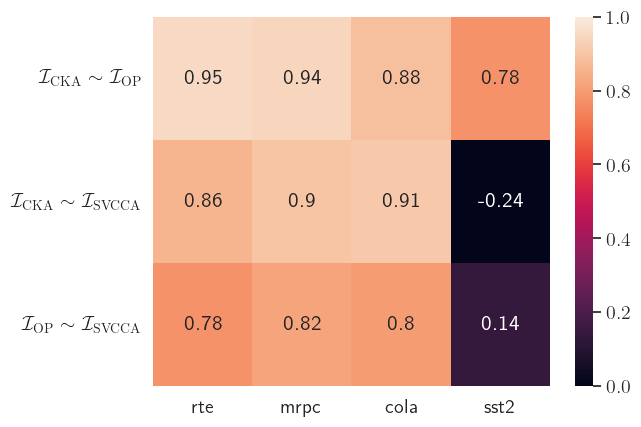

roberta


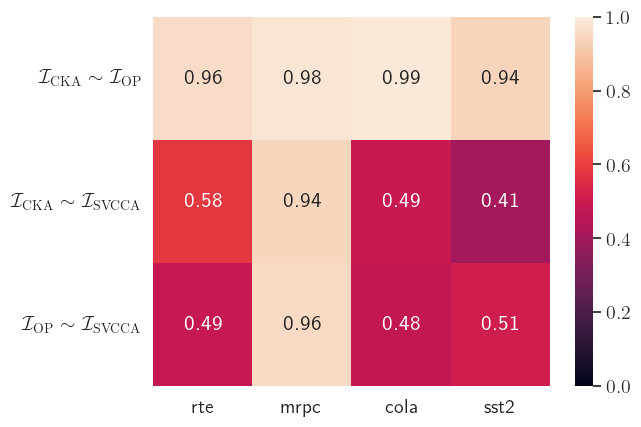

In [6]:
model_names = ['bert', 'roberta']
task_names = ['rte', 'mrpc', 'cola', 'sst2']
lr = '2e-05'
mask_idx = np.triu_indices(20, k=1)

for model_name in model_names:
    print(model_name)
    corr_table = {}
    for task_name in task_names:
        # print(task_name)
        corr_table[task_name] = {}
        h5_path = os.path.join(rep_dir(model_name), 'dist', f'{task_name}_{lr}_original.h5')
        if not os.path.exists(h5_path):
            print(f'{model_name} on {task_name} does not exist')
            continue
        rep_dict = dd.io.load(h5_path)
        measures = list(rep_dict.keys())
        dist_pd = {}
        for measure in rep_dict:
            dist_pd[rm2symbol[measure]] = np.mean(rep_dict[measure][mask_idx], axis=0)
        dist_pd_corr = pd.DataFrame(dist_pd).corr()
        for measure_idx_0 in range(len(measures)):
            for measure_idx_1 in range(measure_idx_0+1, len(measures)):
                measure_0 = rm2symbol[measures[measure_idx_0]]
                measure_1 = rm2symbol[measures[measure_idx_1]]
                corr_table[task_name][f'{measure_0} $\sim$ {measure_1}'] = \
                    dist_pd_corr[measure_0][measure_1]
    sns.heatmap(pd.DataFrame(corr_table), vmin=0, vmax=1, annot=True)
    plt.show()
    plt.close()


### Correlation with Actual Dissimilarity

**Experiment 1** Layers

**Experiment 2** Successful vs. Failed Runs



In [7]:
# construct majority classifier accuracy dict 
model_names = ['bert', 'roberta']
task_names = ['rte', 'mrpc', 'cola', 'sst2']

for model_name in model_names:
    for task_name in task_names:
        model_full_name = model_full_name_dict[model_name]
        fixed_data_path = os.path.join('data/fixed_eval_data/', task_name, model_full_name, 'test.pt')
        fixed_data = torch.load(fixed_data_path, map_location='cpu')
        labels = torch.cat([batch_data['labels'] for batch_data in fixed_data], dim=0)
        majority_acc = float(max(labels.size(0) - torch.sum(labels), torch.sum(labels)) / labels.size(0))
        print(model_name, task_name, majority_acc)
        

bert rte 0.5179855823516846
bert mrpc 0.6715686321258545
bert cola 0.6628352403640747
bert sst2 0.5068807601928711
roberta rte 0.5179855823516846
roberta mrpc 0.6715686321258545
roberta cola 0.6628352403640747
roberta sst2 0.5045871734619141


Successful vs. failed runs
bert rte


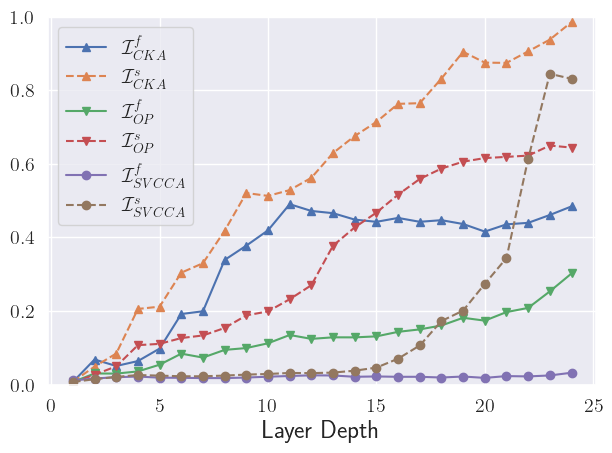

bert mrpc


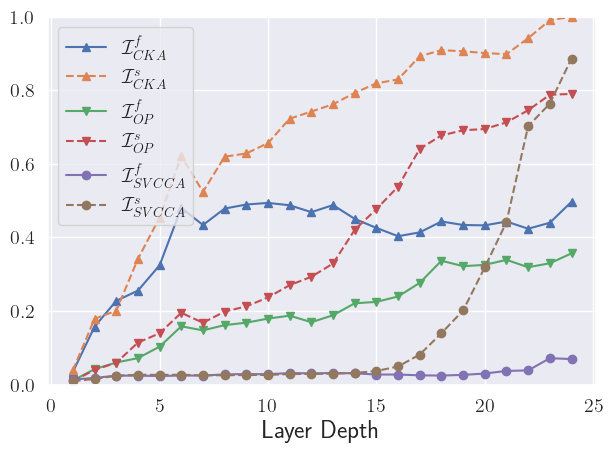

bert cola


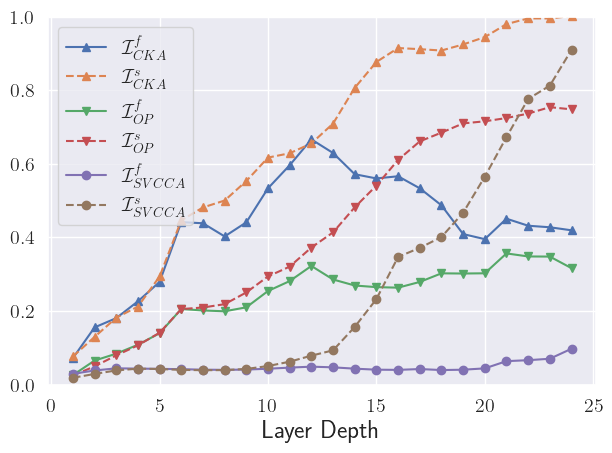

roberta rte


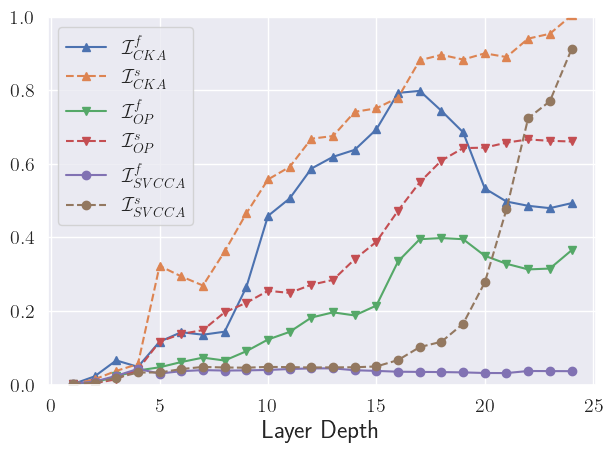

roberta mrpc


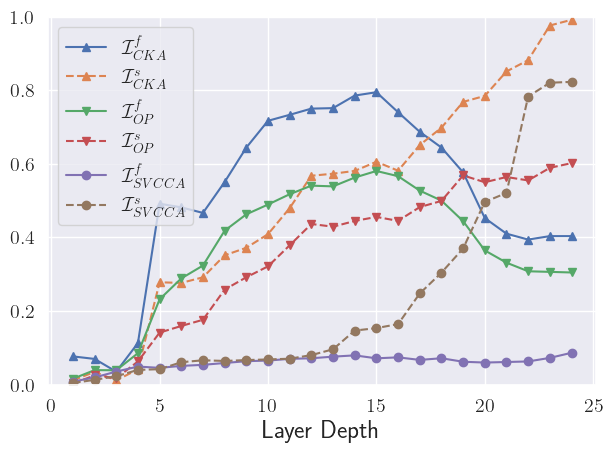

roberta cola


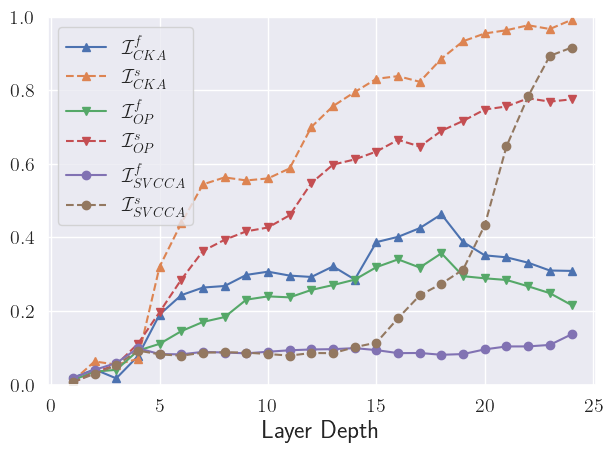

In [8]:
print('Successful vs. failed runs')

lr = '5e-05'

run_type_dict = {
    'bert':{
        'rte': {
            'successful': [1, 3, 4, 6, 10, 12, 13, 16, 18, 19],
            'failed': [0, 2, 5, 7, 8, 9, 11, 14, 15, 17],
        },
        'mrpc': {
            'successful': [2, 3, 4, 5, 7, 13, 14, 16, 17],
            'failed': [0, 1, 6, 8, 9, 10, 11, 12, 15, 18, 19],
        },
        'cola': {
            'successful': [6, 11, 13, 15, 17, 18, 19],
            'failed': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 16],
        }
    },
    'roberta':{
        'rte': {
            'successful': [1, 3, 4, 6, 7, 8, 10, 12, 14],
            'failed': [0, 2, 5, 9, 11, 13, 15, 16, 17, 18, 19],
        },
        'mrpc': {
            'successful': [0, 2, 4, 5, 7, 8, 9, 10, 12, 14, 16, 17, 18],
            'failed': [1, 3, 6, 11, 13, 15, 19],
        },
        'cola': {
            'successful': [1, 2, 4, 6, 8, 10, 11, 12, 14, 16, 18],
            'failed': [0, 3, 5, 7, 9, 13, 15, 17, 19]
        }
    }
}

model2lr = {'bert': 5e-05, 'roberta': 3e-05}
task_names = ['rte', 'mrpc', 'cola']
seeds = list(range(20))

for model_name in model2lr:
    lr = model2lr[model_name]
    for task_name in task_names:
        successful_seeds = run_type_dict[model_name][task_name]['successful']
        failed_seeds = run_type_dict[model_name][task_name]['failed']
        h5_path = os.path.join(
            rep_dir(model_name), 'dist', f'{task_name}_{lr}_original_final.h5')
        rep_dict = dd.io.load(h5_path)
        for measure in rep_dict:
            successful_run_pairs, failed_run_pairs = [], []
            for seed_0_idx, seed_0 in enumerate(seeds):
                for seed_1 in seeds[seed_0_idx+1:]:
                    if seed_0 in successful_seeds and seed_1 in successful_seeds:
                        successful_run_pairs.append(
                            rep_dict[measure][seed_0, seed_1])
                    elif seed_0 in failed_seeds and seed_1 in failed_seeds:
                        failed_run_pairs.append(
                            rep_dict[measure][seed_0, seed_1])
            success_mean = np.mean(successful_run_pairs, axis=0)
            failed_mean = np.mean(failed_run_pairs, axis=0)
            plt.plot(np.arange(1, 25), success_mean, 
                     label=f'{rm_run_type2symbol[measure][1]}', 
                     marker=rm2marker[measure])
            plt.plot(np.arange(1, 25), failed_mean, 
                     label=f'{rm_run_type2symbol[measure][0]}',
                     marker=rm2marker[measure], linestyle='--')

        print(model_name, task_name)
        plt.ylim(0, 1)
        plt.xlabel('Layer Depth', fontsize=18)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()


Bootstrapping
bert
rte original
Standard deviation: 0.016230955644141686


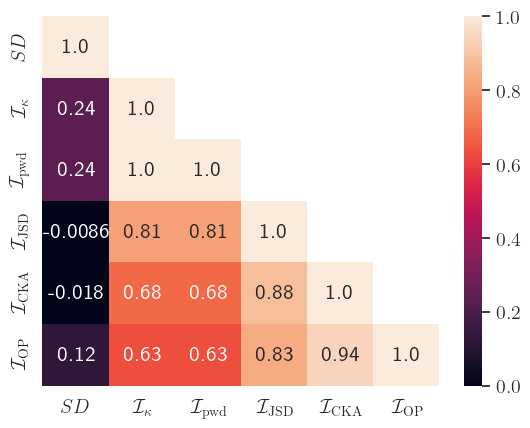

rte mixout
Standard deviation: 0.03249378357017616


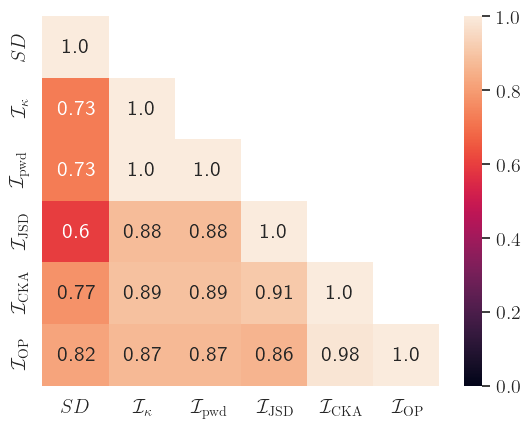

rte llrd
Standard deviation: 0.028195565384554547


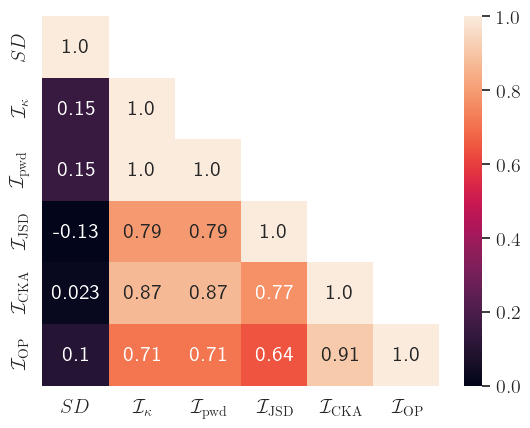

rte reinit
Standard deviation: 0.014316366001534093


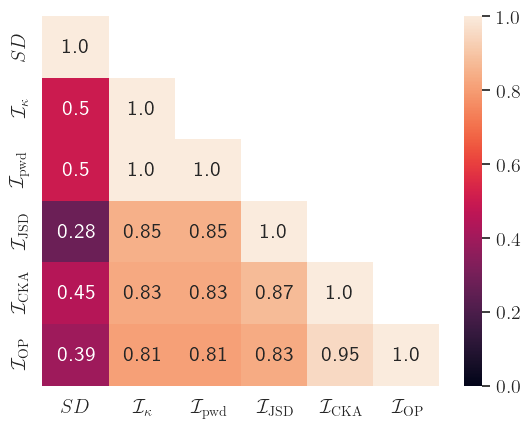

rte wd_pre
Standard deviation: 0.05581917911157073


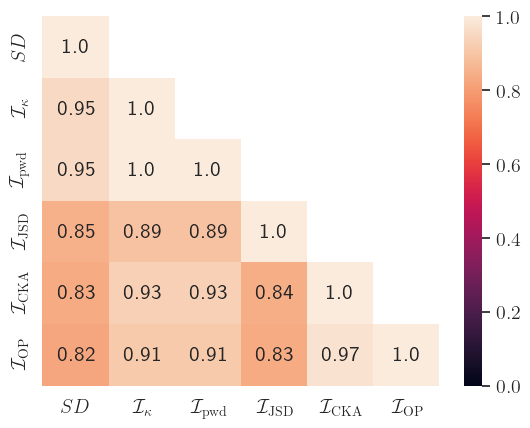

mrpc original
Standard deviation: 0.011016058754396705


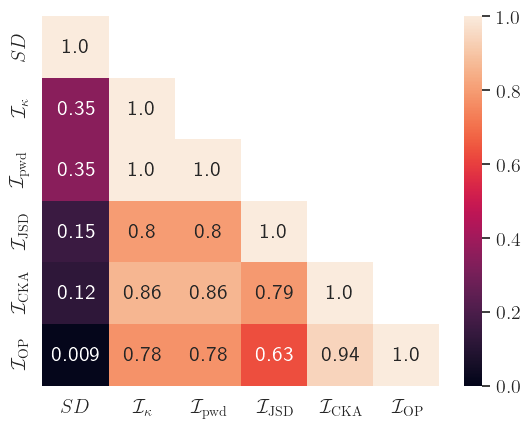

mrpc mixout
Standard deviation: 0.007280681783771959


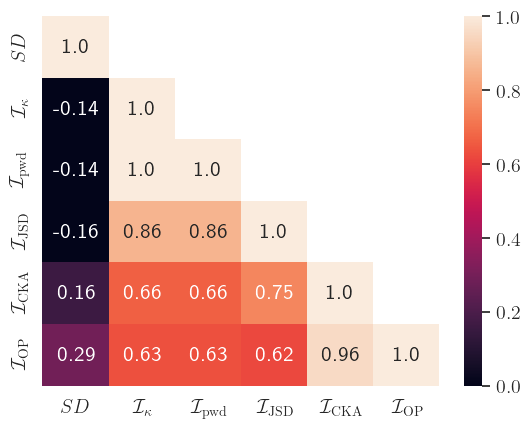

mrpc llrd
Standard deviation: 0.012999678441043064


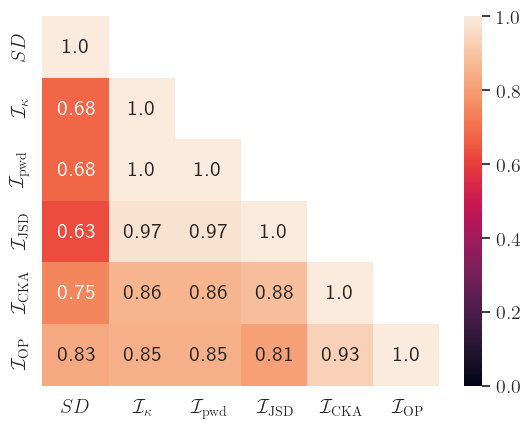

mrpc reinit
Standard deviation: 0.007525709318789424


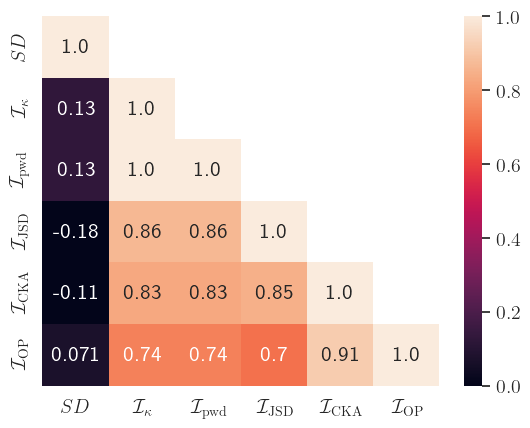

mrpc wd_pre
Standard deviation: 0.012230008201176498


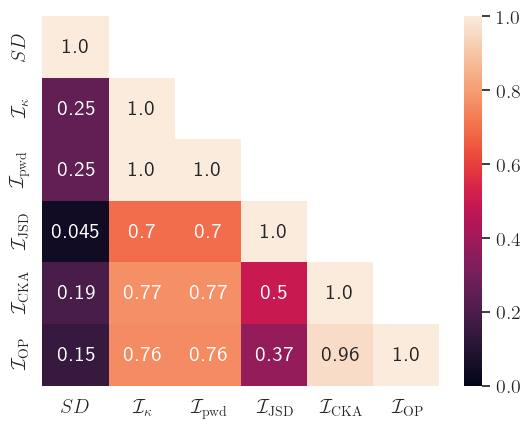

cola original
Standard deviation: 0.07230909837343316


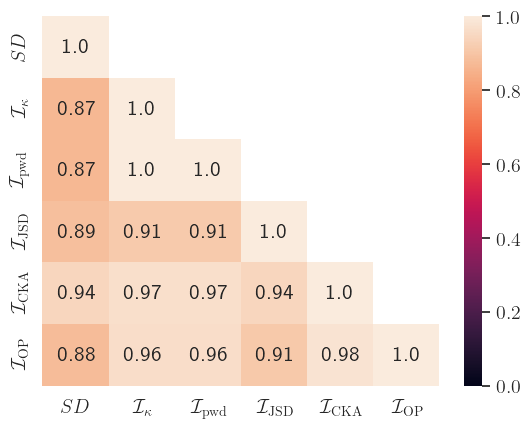

cola mixout
Standard deviation: 0.018885663611023194


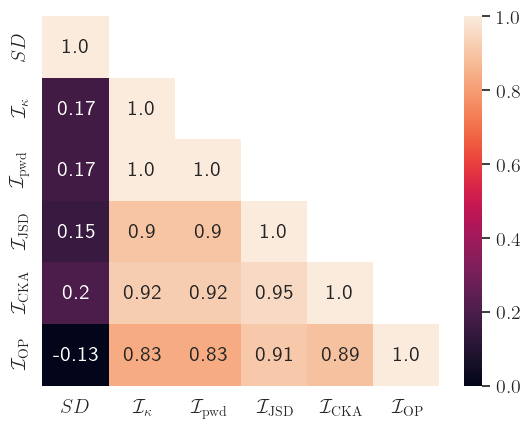

cola llrd
Standard deviation: 0.022717198168970436


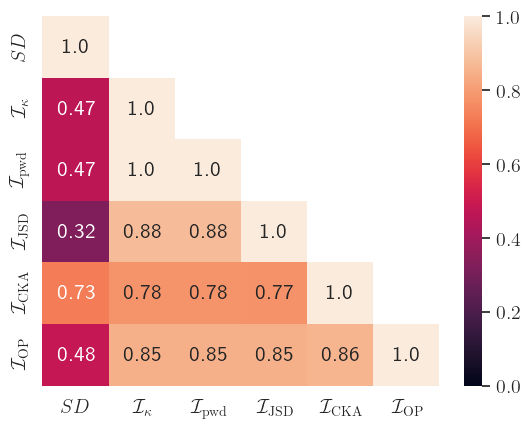

cola reinit
Standard deviation: 0.029188981645655924


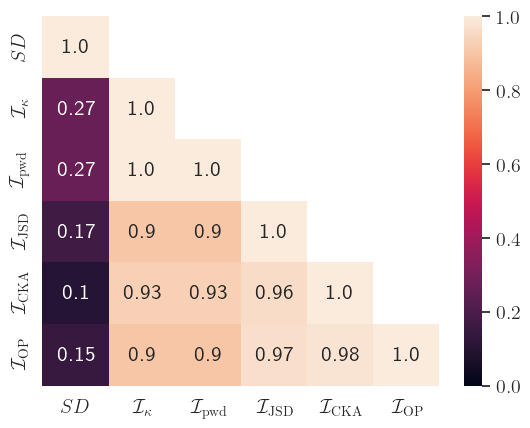

cola wd_pre
Standard deviation: 0.018264200151477707


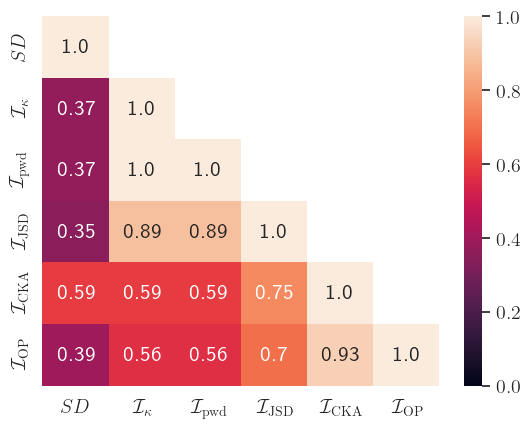

sst2 original
Standard deviation: 0.008063484326260046


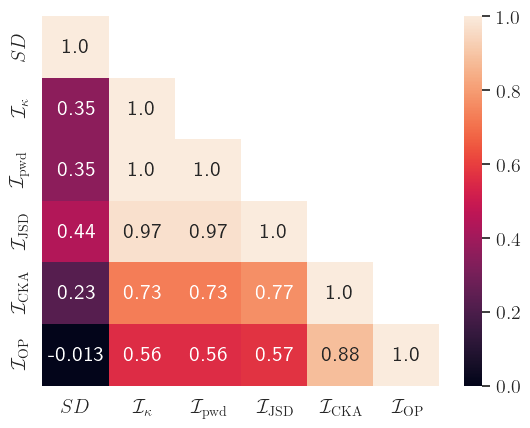

roberta
rte original
Standard deviation: 0.1


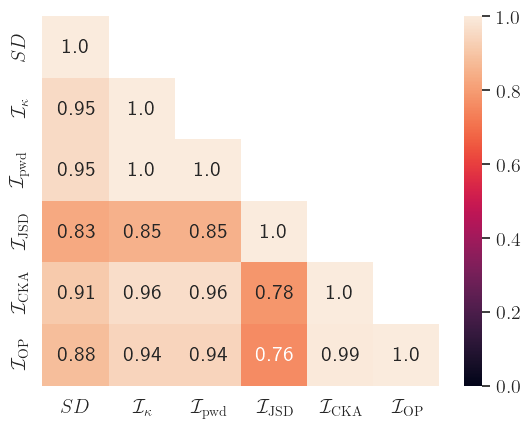

rte mixout
Standard deviation: 0.04444156895390074


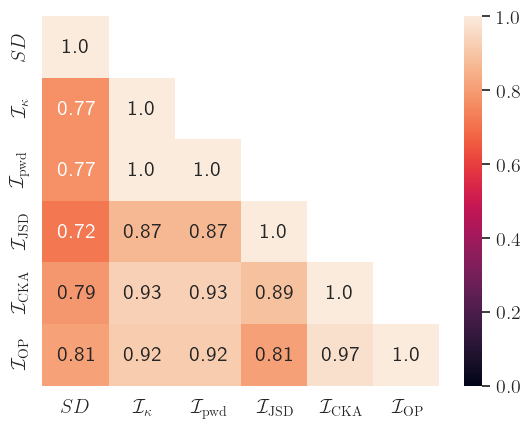

rte llrd
Standard deviation: 0.017913524601422655


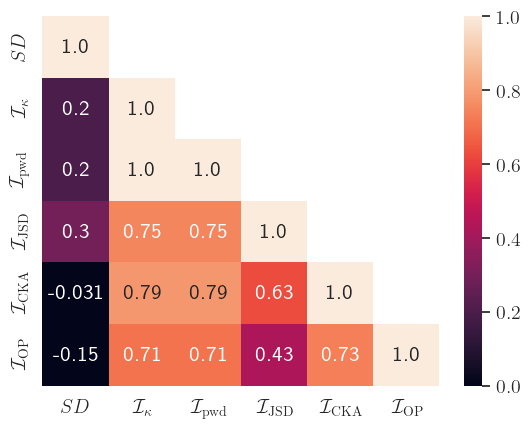

rte reinit
Standard deviation: 0.02036111035695669


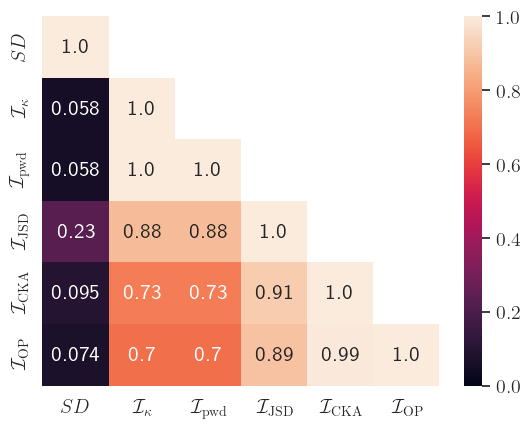

rte wd_pre
Standard deviation: 0.027863189541060554


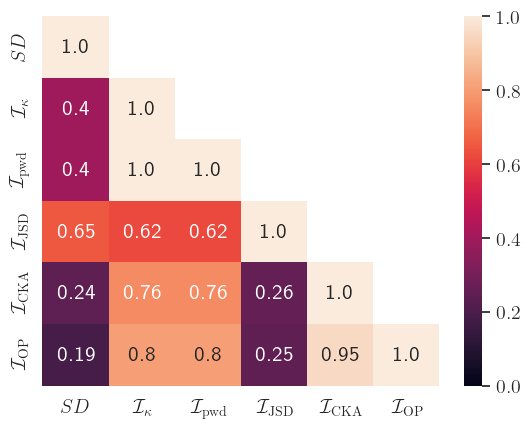

mrpc original
Standard deviation: 0.04847002902469494


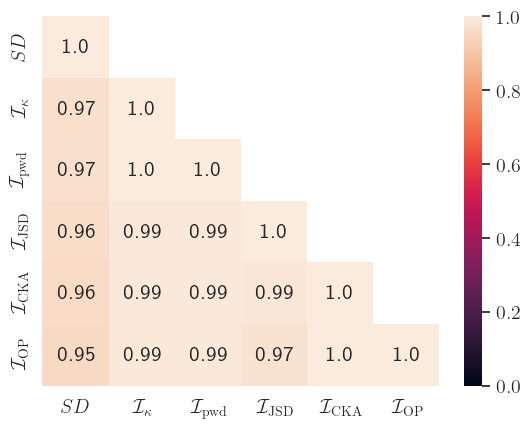

mrpc mixout
Standard deviation: 0.032491616479393214


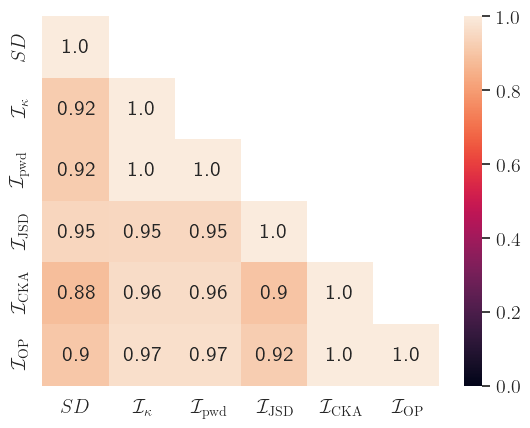

mrpc llrd
Standard deviation: 0.006101906530325247


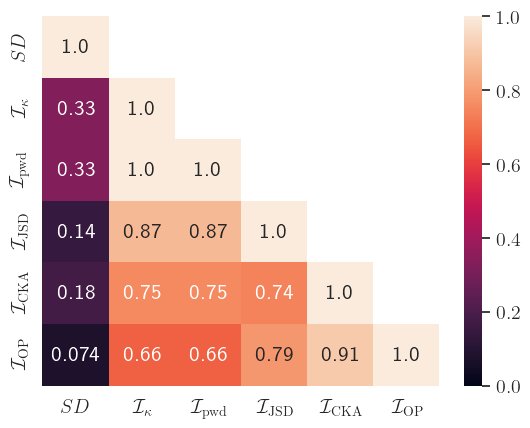

mrpc reinit
Standard deviation: 0.007963157068161924


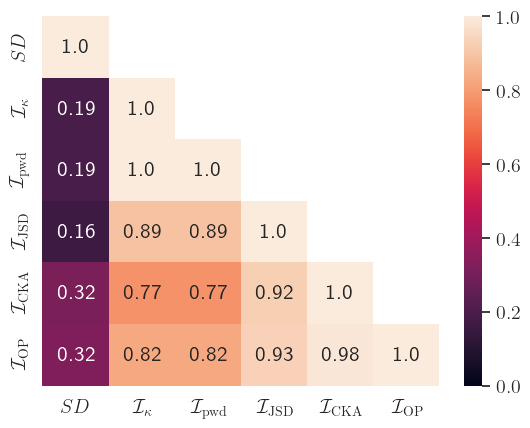

mrpc wd_pre
Standard deviation: 0.010380330712493488


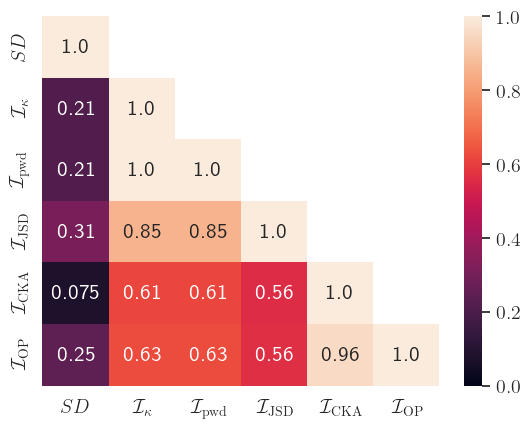

cola original
Standard deviation: 0.09713794554520046


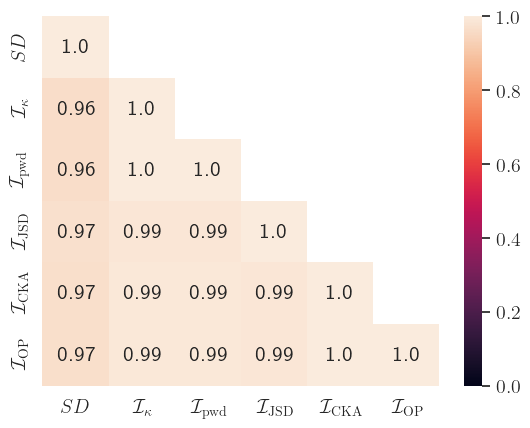

cola mixout
Standard deviation: 0.02215462341316083


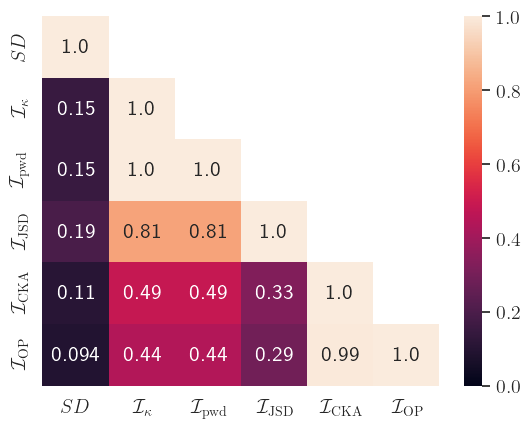

cola llrd
Standard deviation: 0.04108977482499168


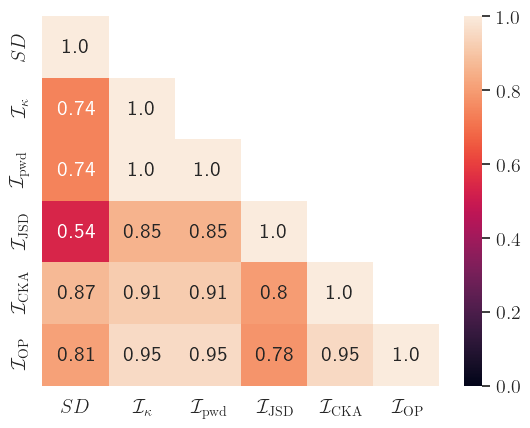

cola reinit
Standard deviation: 0.027225104426064628


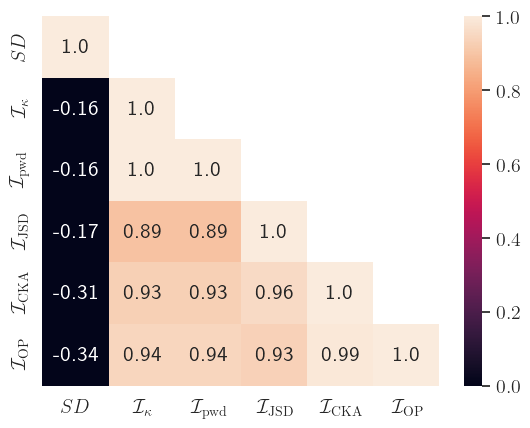

cola wd_pre
Standard deviation: 0.024503862461649175


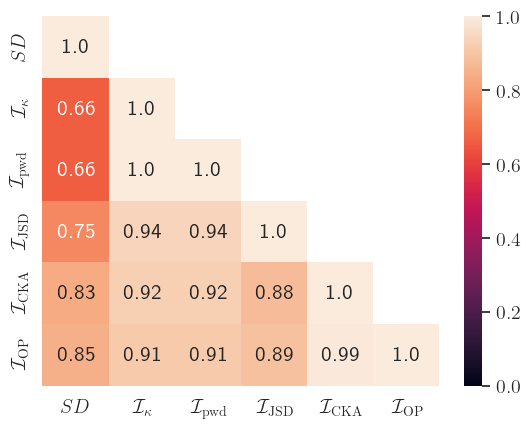

sst2 original
Standard deviation: 0.009426019535795643


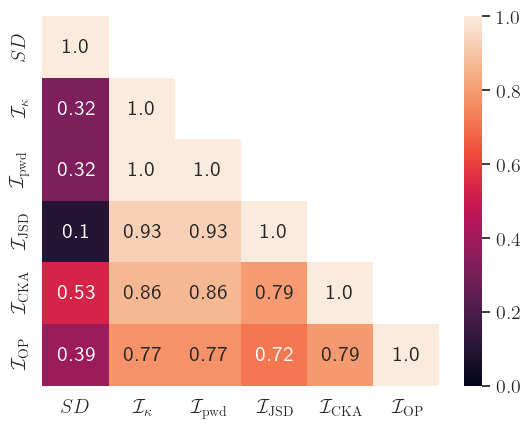

In [9]:
print('Bootstrapping')

lr = '2e-05'
# mitigation_methods = ['original', 'mixout', 'llrd', 'reinit', 'wd_pre']
mitigation_methods = ['original']
bs_times = 1000
# model_names = ['bert', 'roberta']
model_names = ['bert']
# task_names = ['rte', 'mrpc', 'cola', 'sst2']
task_names = ['rte', 'mrpc']

std_dicts, corr_dicts, dist_dicts = {}, {}, {}
for model_name in model_names:
    print(model_name)

    # initialize SD and correlation list
    std_dict, corr_dict = defaultdict(dict), defaultdict(dict)
    # for task_name in task_names:
    for task_name in task_names:
        eval_metric = task2metric[task_name]
        for mitigation_method in mitigation_methods:
            seeds = list(range(10))
            measure_h5_path = os.path.join(
                rep_dir(model_name), 'dist', 
                f'{task_name}_{lr}_{mitigation_method}.h5')
            prediction_h5_path = os.path.join(
                pred_dir(model_name), 
                f'{task_name}_{lr}_{mitigation_method}.h5')
            if not os.path.exists(measure_h5_path) \
                or not os.path.exists(prediction_h5_path):
                continue

            print(task_name, mitigation_method)
            prediction_dict = dd.io.load(prediction_h5_path)
            rep_dict = dd.io.load(measure_h5_path)

            # calculate SD
            logits_dict = prediction_dict['test']['logits']
            eval_metric_dict = prediction_dict['test']['eval_metric']
            std = np.std(np.array([eval_metric_dict[seed][eval_metric] 
                                   for seed in seeds]))
            print(f'Standard deviation: {std}')

            # perform bootstrapping
            dists = defaultdict(list)
            for _ in range(bs_times):

                # sample seeds and compute SD for these seeds
                sample_seeds = sorted(random.choices(seeds, k=len(seeds)))
                # sample_seeds = random.choices(seeds, k=len(seeds))
                dists[pm2symbol[f'std_{task2metric[task_name]}']].append(
                    np.std(np.array([eval_metric_dict[seed][eval_metric] 
                                     for seed in sample_seeds])))

                # to calculate Fleiss' Kappa
                logits_list = [logits_dict[seed] for seed in sample_seeds]
                dists[pm2symbol['fleiss_kappa']].append(
                    1 - fleiss_kappa(logits_list))

                # to calculate JSD, disagreement, CKA, OP
                stats = defaultdict(list)  # values of these samples
                for seed_0_idx, seed_0 in enumerate(sample_seeds):
                    logits_0 = logits_dict[seed_0]
                    for seed_1 in sample_seeds[seed_0_idx+1:]:
                        logits_1 = logits_dict[seed_1]
                        stats[pm2symbol['avg_disagreement']].append(
                            avg_disagreement(logits_0, logits_1))
                        stats[pm2symbol['jsd']].append(
                            np.mean(jsd(logits_0, logits_1)))
                        stats[rm2symbol['cka_dists']].append(
                            rep_dict['cka_dists'][seed_0, seed_1, -1])
                        stats[rm2symbol['op_dists']].append(
                            rep_dict['op_dists'][seed_0, seed_1, -1])
                for measure in stats:  # averages of different samples
                    dists[measure].append(np.mean(np.array(stats[measure])))

            # calculate the bootstrapping correlations between each pair of measures
            corr = pd.DataFrame(dists).corr()
            # select correlations between SD and each one of the other measures
            if task_name != 'sst2':
                std_dict[mitigation_method][task_name] = std
                corr_dict[mitigation_method][task_name] = corr

            # paint figure
            mask = np.triu(np.ones((len(dists), len(dists))), k=1)
            with sns.axes_style("white"):
                sns.heatmap(
                    corr, mask=mask, vmax=1, vmin=0, annot=True, fmt='.2')
                plt.show()
                plt.close()
    std_dicts[model_name], corr_dicts[model_name] = std_dict, corr_dict


model: bert, overall: r=0.7337610331019789, p=1.9334941744510226e-16


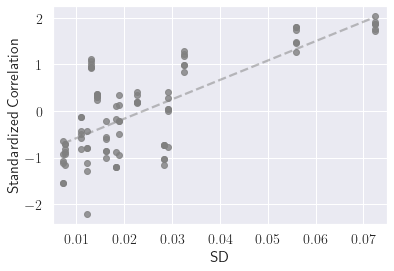

model: roberta, overall: r=0.6534165571544001, p=2.9334752508024523e-12


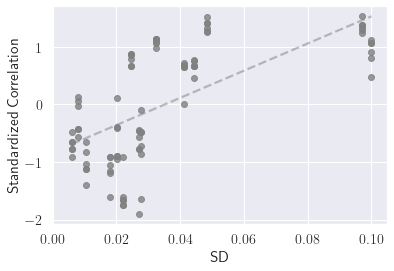

In [172]:
def standardize(x):
    x = np.array(x)
    x = (x - x.mean()) / np.std(x)
    return x.tolist()

model_names = ['bert', 'roberta']
task_names = ['rte', 'mrpc', 'cola']
mitigation_methods = ['original', 'mixout', 'llrd', 'reinit', 'wd_pre']


measures = list(
    corr_dicts[model_names[0]][mitigation_methods[0]][task_names[0]].keys())

for model_name in model_names:
    sd_list = reduce(
        lambda x, y: x + y, 
        [[std_dicts[model_name][mitigation_method][task_name] 
          for mitigation_method in mitigation_methods 
          for task_name in task_names] 
        for measure in measures])
    corr_list = reduce(
        lambda x, y: x + y, 
        [standardize([
            corr_dicts[model_name][mitigation_method][task_name][measure].mean() 
            for mitigation_method in mitigation_methods 
            for task_name in task_names])
        for measure in measures])

    overall_r, overall_p = pearsonr(sd_list, corr_list)
    print(f'model: {model_name}, overall: r={overall_r}, p={overall_p}')

    sns.regplot(x=sd_list, y=corr_list, ci=None,
            scatter=True, color='grey', 
            line_kws={'linestyle': '--', 'alpha': 0.5})
    plt.xlabel('SD')
    plt.ylabel('Standardized Correlation')
    if model_name == 'bert':
        plt.xlim(0.005, 0.075)
    elif model_name == 'roberta':
        plt.xlim(0, 0.105)
    plt.show()
    plt.close()


In [177]:
lr = '2e-05'
# model, task, mitigation, measure
tau_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))  
mitigation_methods = ['original', 'mixout', 'llrd', 'reinit', 'wd_pre']
model_names = ['bert', 'roberta']
task_names = ['rte', 'mrpc', 'cola', 'sst2']

for model_name in model_names:
    print(model_name)
    result_pd_dict = {}
    for task_name in task_names:
        print(task_name)
        eval_metric = task2metric[task_name]
        eval_metric_abv = metric2abv[task_name]

        result_pd = {}
        for mitigation_method in mitigation_methods:
            pd_series = {}
            seeds = list(range(20)) if mitigation_method == 'original' \
                else list(range(10))

            result_pd[mitigation_method] = {}
            measure_h5_path = os.path.join(
                rep_dir(model_name), 'dist', 
                f'{task_name}_{lr}_{mitigation_method}.h5')
            prediction_h5_path = os.path.join(
                pred_dir(model_name), 
                f'{task_name}_{lr}_{mitigation_method}.h5')
            if not os.path.exists(measure_h5_path) \
                or not os.path.exists(prediction_h5_path):
                continue
            prediction_dict = dd.io.load(prediction_h5_path)

            logits_dict = prediction_dict['test']['logits']
            eval_metric_dict = prediction_dict['test']['eval_metric']
            eval_scores = np.array(
                [eval_metric_dict[seed][eval_metric] for seed in seeds])
            pd_series[eval_metric_abv] = np.mean(eval_scores)
            tau_dict[model_name][task_name][mitigation_method]['SD'] = \
                pd_series[f'$\sigma_{eval_metric_abv}$'] = np.std(eval_scores)

            jsd_list = []
            avg_disagreement_list = []
            logits_list = []
            cka_list = []
            op_list = []
            for seed_0_idx, seed_0 in enumerate(seeds):
                logits_0 = logits_dict[seed_0]
                eval_res_0 = eval_metric_dict[seed_0][eval_metric]
                logits_list.append(logits_0)
                for seed_1 in seeds[seed_0_idx+1:]:
                    logits_1 = logits_dict[seed_1]
                    eval_res_1 = eval_metric_dict[seed_1][eval_metric]
                    jsd_list.append(np.mean(jsd(logits_0, logits_1)))
                    avg_disagreement_list.append(
                        avg_disagreement(logits_0, logits_1))

            tau_dict[model_name][task_name][mitigation_method]['jsd'] = \
                pd_series[pm2symbol['jsd']] = np.mean(np.array(jsd_list))
            tau_dict[model_name][task_name][mitigation_method]['fleiss_kappa'] \
                = pd_series[pm2symbol['fleiss_kappa']] = \
                1 - fleiss_kappa(logits_list)
            tau_dict[model_name][task_name][mitigation_method]['avg_disagreement'] \
                = pd_series[pm2symbol['avg_disagreement']] = \
                np.mean(np.array(avg_disagreement_list))
            result_pd[mitigation_method] = pd.Series(pd_series)
        result_pd = pd.DataFrame(result_pd).T
        result_pd_dict[task_name] = result_pd
        print(result_pd.to_csv())


bert
rte
,Acc,$\sigma_Acc$,$\mathcal{I}_{\mathrm{JSD}}$,$\mathcal{I}_{\mathrm{\kappa}}$,$\mathcal{I}_{\mathrm{pwd}}$
original,0.7133093525179856,0.017662566470778285,0.06781883537769318,0.1387109077040426,0.13771298750473307
mixout,0.7122302158273381,0.03249378357017616,0.07889063656330109,0.15523349436392908,0.15411670663469226
llrd,0.6920863309352518,0.028195565384554547,0.053872250020504,0.13816425120772946,0.13717026378896882
reinit,0.7035971223021582,0.014316366001534093,0.04737549275159836,0.10080515297906611,0.10007993605115909
wd_pre,0.7050359712230215,0.05581917911157073,0.07392723113298416,0.1800322061191627,0.17873701039168666

mrpc
,F1,$\sigma_F1$,$\mathcal{I}_{\mathrm{JSD}}$,$\mathcal{I}_{\mathrm{\kappa}}$,$\mathcal{I}_{\mathrm{pwd}}$
original,0.8934906842901789,0.012161703784381668,0.05144959315657616,0.09144412756027998,0.09099587203302374
mixout,0.8959014309820814,0.007280681783771959,0.0481296107172966,0.0888888888888889,0.08845315904139436
llrd,0.8948843588541988,0.01

Show Layer Results
rte_bert_cka [('reinit', 0.18), ('llrd', 0.29), ('original', 0.34), ('mixout', 0.37), ('wd_pre', 0.46)]


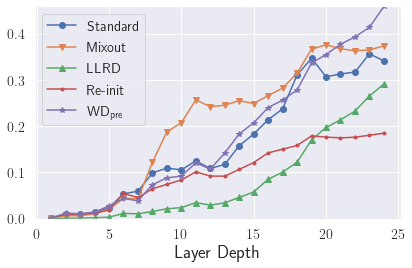

rte_bert_op [('reinit', 0.1), ('llrd', 0.16), ('original', 0.2), ('mixout', 0.21), ('wd_pre', 0.26)]


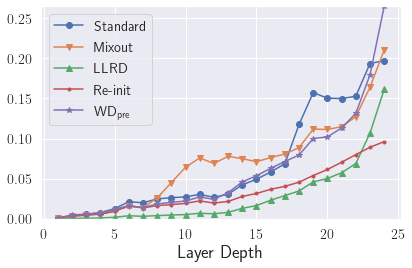

rte_roberta_cka [('llrd', 0.28), ('reinit', 0.29), ('wd_pre', 0.41), ('mixout', 0.47), ('original', 0.59)]


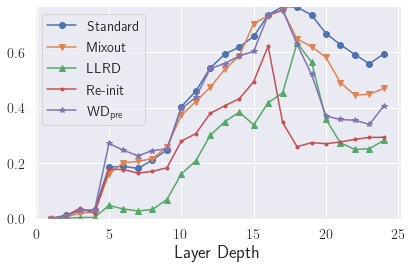

rte_roberta_op [('reinit', 0.18), ('llrd', 0.2), ('wd_pre', 0.29), ('mixout', 0.34), ('original', 0.39)]


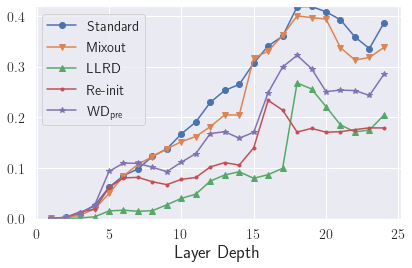

mrpc_bert_cka [('reinit', 0.17), ('llrd', 0.2), ('original', 0.26), ('wd_pre', 0.29), ('mixout', 0.32)]


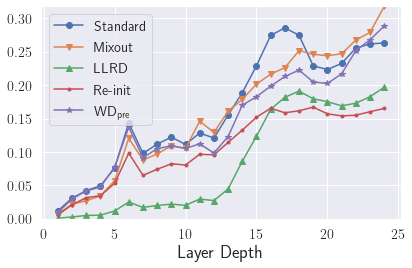

mrpc_bert_op [('reinit', 0.11), ('llrd', 0.14), ('original', 0.18), ('mixout', 0.21), ('wd_pre', 0.21)]


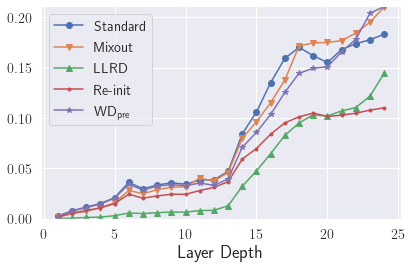

mrpc_roberta_cka [('reinit', 0.14), ('llrd', 0.19), ('wd_pre', 0.26), ('original', 0.35), ('mixout', 0.52)]


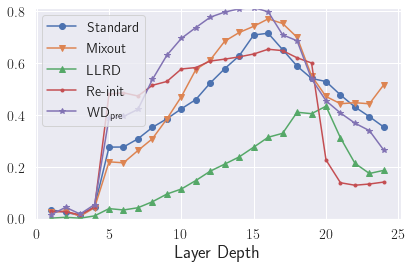

mrpc_roberta_op [('reinit', 0.09), ('llrd', 0.16), ('wd_pre', 0.21), ('original', 0.3), ('mixout', 0.38)]


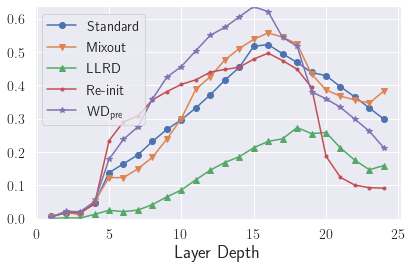

cola_bert_cka [('llrd', 0.14), ('mixout', 0.19), ('reinit', 0.19), ('wd_pre', 0.22), ('original', 0.27)]


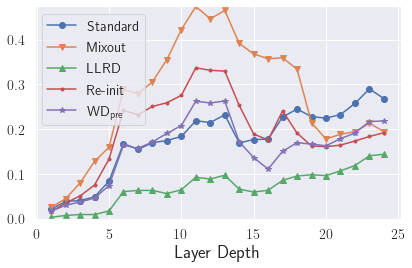

cola_bert_op [('llrd', 0.11), ('reinit', 0.13), ('wd_pre', 0.15), ('mixout', 0.16), ('original', 0.2)]


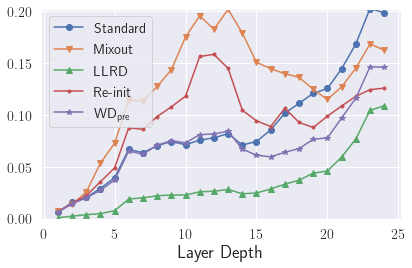

cola_roberta_cka [('reinit', 0.21), ('llrd', 0.25), ('wd_pre', 0.33), ('original', 0.37), ('mixout', 0.41)]


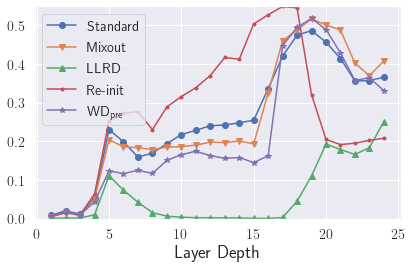

cola_roberta_op [('reinit', 0.13), ('llrd', 0.19), ('wd_pre', 0.23), ('original', 0.26), ('mixout', 0.26)]


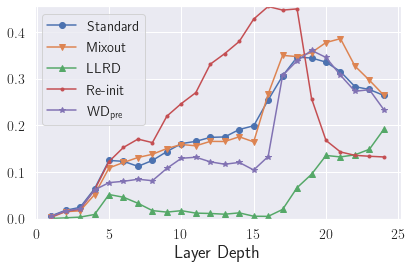

In [31]:
print('Show Layer Results')

def filter_index(idx, num_set):
    x_list, y_list = [], []
    for x, y in zip(*idx):
        if x in num_set or y in num_set:
            continue
        else:
            x_list.append(x)
            y_list.append(y)
    return np.array(x_list), np.array(y_list)

lr = '2e-05'
mitigation_methods = {
    'original': 'Standard',
    'mixout': 'Mixout',
    'llrd': 'LLRD',
    'reinit': 'Re-init',
    'wd_pre': '$\mathsf{WD_{pre}}$'}
mitigation_to_marker = {
    'original': 'o',
    'mixout': 'v',
    'llrd': '^',
    'reinit': '.',
    'wd_pre': '*'
}
measures = ['cka_dists', 'op_dists']

mask_idx = np.triu_indices(10, k=1)

for task_name in task_names:
    for model_name in model_names:
        for measure in measures:
            max_instability = -float('inf')
            measure_name = rm2symbol[measure]
            measure_prefix = measure.split('_')[0]
            fig_name = f'{task_name}_{model_name}_{measure_prefix}'

            last_layer = []
            for mitigation_method in mitigation_methods:
                # load data
                num_seeds = 20 if mitigation_method == 'original' else 10
                mask_idx = np.triu_indices(num_seeds, k=1)
                measure_h5_path = os.path.join(rep_dir(model_name), 'dist', f'{task_name}_{lr}_{mitigation_method}.h5')
                rep_dict = dd.io.load(measure_h5_path)
                # process data
                measure_instability = np.mean(rep_dict[measure][mask_idx], axis=0)  # num_layers
                max_instability = max(np.max(measure_instability), max_instability)
                last_layer.append((mitigation_method, round(float(measure_instability[-1]), 2)))
                tau_dict[model_name][task_name][mitigation_method][measure] = float(measure_instability[-1])
                # paint data
                plt.plot(np.arange(1, measure_instability.shape[0] + 1), measure_instability,
                         label=mitigation_methods[mitigation_method], marker=mitigation_to_marker[mitigation_method])
            print(fig_name, sorted(last_layer, key=lambda x: x[1]))

            plt.xlabel('Layer Depth', fontsize=18)
            plt.ylim(0, max_instability)
            plt.legend()
            plt.tight_layout()
            plt.show()
            plt.close()


bert rte


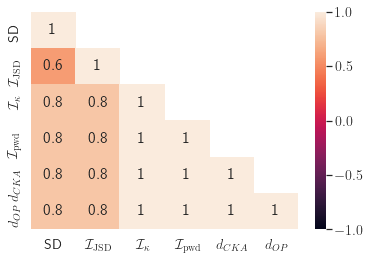

bert mrpc


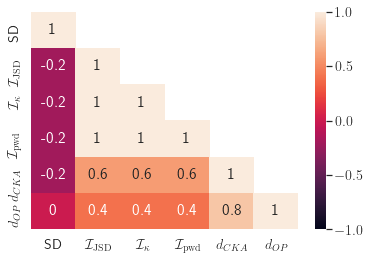

bert cola


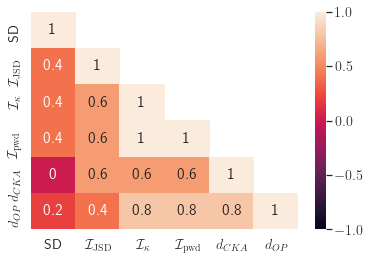

roberta rte


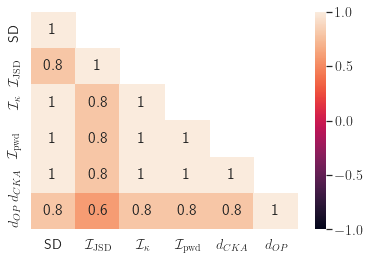

roberta mrpc


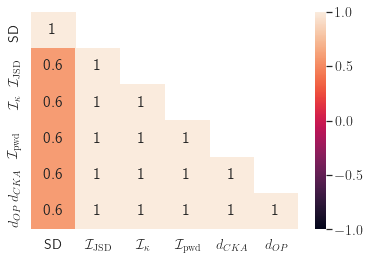

roberta cola


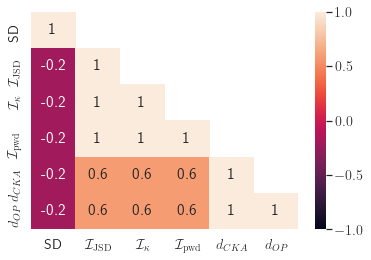

In [32]:
model_names = ['bert', 'roberta']
task_names = ['rte', 'mrpc', 'cola']

for model_name in model_names:
    for task_name in task_names:
        result_pd = pd.DataFrame(tau_dict[model_name][task_name]).T
        tau_pd = defaultdict(dict)
        for measure_idx, measure_0 in enumerate(result_pd.columns):
            measure_name_0 = latex_format[measure_0] if measure_0 in latex_format else measure_0
            tau_pd[measure_name_0][measure_name_0] = 1.0
            for measure_1 in result_pd.columns[measure_idx+1:]:
                measure_name_1 = latex_format[measure_1] if measure_1 in latex_format else measure_1
                corr_res = pg.corr(result_pd[measure_0], result_pd[measure_1], method='kendall')
                r, power = float('{:.3f}'.format(corr_res['r']['kendall'])), float('{:.3f}'.format(corr_res['power']['kendall']))
                tau_pd[measure_name_0][measure_name_1] = tau_pd[measure_name_1][measure_name_0] = r
        tau_pd = pd.DataFrame(tau_pd)
        mask = np.triu(np.ones_like(tau_pd, dtype=bool), k=1)
        with sns.axes_style("white"):
            print(model_name, task_name)
            sns.heatmap(tau_pd, annot=True, vmin=-1, vmax=1, mask=mask)
            plt.show()
            plt.close()
